In [70]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle 

In [71]:
ID = "0001" 

In [ ]:
# Noise data for CCE sims 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    params = pickle.load(f)

with open('R_dict_sim_lm_full.pkl', 'rb') as f:
    R = pickle.load(f)

Set up all parameters for minimal working example 

In [ ]:
######################################################################################################

# Mock data parameters 

DATA_AMPS = [0.4, 0.2, -0.04, -0.2] # These are based on 0001 

DATA_QNMS = [(2, 2, 0, 1), (2, 2, 1, 1)]
DATA_SPHERICAL_MODES = [(2, 2)]
sim_main = CCE.SXS_CCE(ID, lev="Lev5", radius="R2")
DATA_MASS = sim_main.Mf
DATA_SPIN = sim_main.chif_mag 

DATA_TIME_STEP = 0.1

DATA_T0 = -10 # This needs to be consistent with training start (can't start arbitrarily far back)
DATA_T = 100

data_times = np.arange(
    DATA_T0, DATA_T0 + DATA_T, DATA_TIME_STEP
)

####################################################################################################

TRAINING_TIME_STEP = 0.1 
TRAINING_T0 = -10
TRAINING_T = 100

training_times = np.arange(
    TRAINING_T0, TRAINING_T0 + TRAINING_T, TRAINING_TIME_STEP
)

TRAINING_SPH_MODES = [(2,2)]


####################################################################################################

ANALYSIS_TIME_STEP = 0.1
ANALYSIS_T0 = 10
ANALYSIS_T = 100

analysis_times = np.arange(
    ANALYSIS_T0, ANALYSIS_T0 + ANALYSIS_T, ANALYSIS_TIME_STEP
)

MODEL = [(2,2,0,1), (2,2,1,1)]
SPH_MODES = [(2,2)]



Functions to get mock data and noise

In [ ]:
# Get mock data with noise functions

def get_mock_data(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    mock_data = {mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes}
    for i, qnm in enumerate(qnm_list):
        amp = amps[2 * i] + 1j * amps[2 * i + 1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            mock_data[ell, m] += amp * mu * np.exp(-1j * omega * (times - t0))
    return mock_data

def get_noisy_mock_data(mock_data, kernel_dict, times):
    data = mock_data.copy()
    rng = np.random.default_rng()
    repeats = 1
    noise = {mode: np.zeros_like(times, dtype=complex) for mode in mock_data.keys()}
    for ell, m in data.keys():
        gp_samples = rng.multivariate_normal(np.zeros(len(times)), kernel_dict[ell,m], size=repeats)
        for j, draw in enumerate(gp_samples):
            data[ell, m] += draw
            noise[ell, m] += draw 
        #noise[ell, m] /= np.sqrt(repeats)
    return data, noise

In [ ]:
tuning_hyperparams_data = [1, 0, 3, 0.5] 

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

tuned_params_data = {mode: get_new_params(params[ID][mode], tuning_hyperparams_data, HYPERPARAM_RULE_DICT) for mode in params[ID]}

In [ ]:
mock_kernel_dict = {
    mode: compute_kernel_matrix(data_times, tuned_params_data[mode], kernel_main)
    for mode in tuned_params_data.keys()
}

mock_h = get_mock_data(data_times, DATA_T0, DATA_AMPS, DATA_QNMS, DATA_SPHERICAL_MODES, DATA_MASS, DATA_SPIN)
data, noise = get_noisy_mock_data(mock_h, mock_kernel_dict, data_times)

###################################################################################################################################

In [ ]:
# White noise

tuning_hyperparams_s = [0.3996582031249995]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(params[ID][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in params[ID]}

In [ ]:
tuning_hyperparams_lm = [1, 0, 3, 0.5] 

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

tuned_params_lm = {mode: get_new_params(params[ID][mode], tuning_hyperparams_data, HYPERPARAM_RULE_DICT) for mode in params[ID]}

In [77]:
fit_main = qnm_BGP_fit(
        data_times,
        data,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_params_lm,
        kernel_test_stationary,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )

In [ ]:
sampling_rates = np.arange(0.01, 1, 0.01)
SD_re0 = []
SD_re1 = []
SD_re2 = []

SD_re0_wn = []
SD_re1_wn = []
SD_re2_wn = []

for i, dt in enumerate(sampling_rates):
        
        data_times_downsampled = np.arange(
                DATA_T0, DATA_T0 + DATA_T, dt
                )
    
        data_downsampled = sim_interpolator_data(data, data_times, data_times_downsampled)

        fit_wn_downsampled = qnm_BGP_fit(
                data_times_downsampled,
                data_downsampled,
                MODEL,
                DATA_MASS,
                DATA_SPIN,
                ANALYSIS_T0,
                tuned_param_dict_wn,
                kernel_s,
                t0_method="geq",
                T=ANALYSIS_T,
                spherical_modes=SPH_MODES,
        )

        fit_main_downsampled = qnm_BGP_fit(
                data_times_downsampled,
                data_downsampled,
                MODEL,
                DATA_MASS,
                DATA_SPIN,
                ANALYSIS_T0,
                tuned_params_lm,
                kernel_test_stationary,
                t0_method="geq",
                T=ANALYSIS_T,
                spherical_modes=SPH_MODES,
        )

        samples_downsampled = scipy.stats.multivariate_normal(fit_main_downsampled['mean'], fit_main_downsampled['covariance'], allow_singular=True).rvs(
        size=100000
        )

        samples_downsampled_wn = scipy.stats.multivariate_normal(fit_wn_downsampled['mean'], fit_wn_downsampled['covariance'], allow_singular=True).rvs(
        size=100000
        )

        std_dev_downsampled = np.std(samples_downsampled, axis=0)
        std_dev_downsampled_wn = np.std(samples_downsampled_wn, axis=0)

        SD_re0.append(std_dev_downsampled[0])
        SD_re1.append(std_dev_downsampled[3])
        SD_re2.append(std_dev_downsampled[5])

        SD_re0_wn.append(std_dev_downsampled_wn[0])
        SD_re1_wn.append(std_dev_downsampled_wn[3])
        SD_re2_wn.append(std_dev_downsampled_wn[5])


Fitted parameters fundamental: a = 0.0014528450117378907, b = -0.39046256659889783
Fitted parameters first overtone: a = 0.002451505196954139, b = -0.3637784034639526
Fitted parameters second overtone: a = 0.001077828687725928, b = -0.3277220271661918


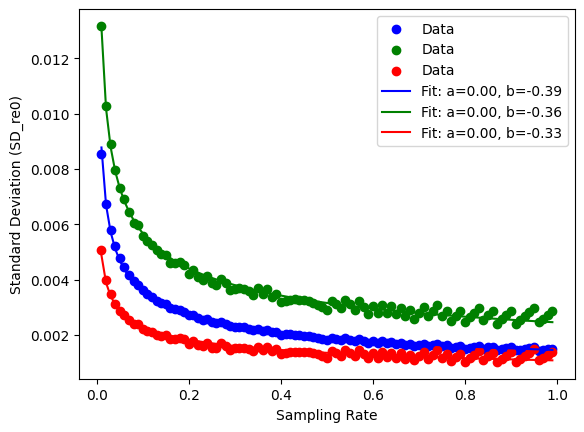

In [94]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

# Fit the data
params_0, covariance_0 = curve_fit(power_law, sampling_rates, SD_re0)
params_1, covariance_1 = curve_fit(power_law, sampling_rates, SD_re1)
params_2, covariance_2 = curve_fit(power_law, sampling_rates, SD_re2)

# Extract the fitted parameters
a_0, b_0 = params_0
a_1, b_1 = params_1
a_2, b_2 = params_2
print(f"Fitted parameters fundamental: a = {a_0}, b = {b_0}")
print(f"Fitted parameters first overtone: a = {a_1}, b = {b_1}")
print(f"Fitted parameters second overtone: a = {a_2}, b = {b_2}")

# Plot the data and the fitted curve
plt.scatter(sampling_rates, SD_re0, label='Data', color='blue')
plt.scatter(sampling_rates, SD_re1, label='Data', color='green')
plt.scatter(sampling_rates, SD_re2, label='Data', color='red')
plt.plot(sampling_rates, power_law(sampling_rates, a_0, b_0), label=f'Fit: a={a_0:.2f}, b={b_0:.2f}', color='blue')
plt.plot(sampling_rates, power_law(sampling_rates, a_1, b_1), label=f'Fit: a={a_1:.2f}, b={b_1:.2f}', color='green')
plt.plot(sampling_rates, power_law(sampling_rates, a_2, b_2), label=f'Fit: a={a_2:.2f}, b={b_2:.2f}', color='red')
plt.xlabel('Sampling Rate')
plt.ylabel('Standard Deviation (SD_re0)')
plt.legend()
plt.show()

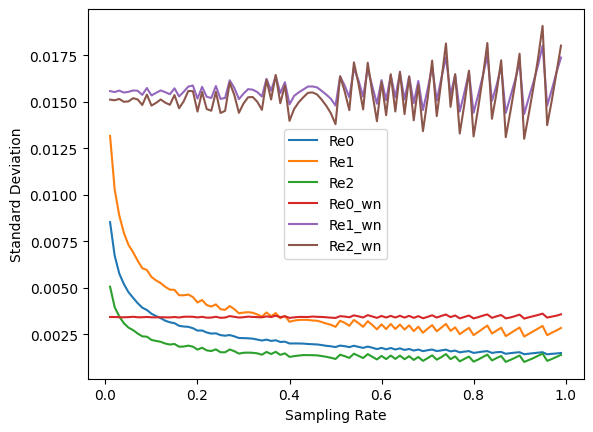

In [95]:
plt.plot(sampling_rates, SD_re0, label='Re0')
plt.plot(sampling_rates, SD_re1, label='Re1')
plt.plot(sampling_rates, SD_re2, label='Re2')
plt.plot(sampling_rates, SD_re0_wn, label='Re0_wn')
plt.plot(sampling_rates, SD_re1_wn, label='Re1_wn')
plt.plot(sampling_rates, SD_re2_wn, label='Re2_wn')
plt.xlabel('Sampling Rate')
plt.ylabel('Standard Deviation')
plt.legend()